In [1]:
#imports
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
data_dir = "/Users/samuel/Desktop/EKU Tübingen/data_literacy/project/data"  
meta_file = os.path.join(data_dir, "META_File_IDs_Age_Gender_Education_Drug_Smoke_SKID_LEMON.csv")

In [3]:
# Relevant file paths for cognitive and emotional tests
emotion_files = [
    "Emotion_and_Personality_Test_Battery_LEMON/ERQ.csv",
    "Emotion_and_Personality_Test_Battery_LEMON/CERQ.csv",
    "Emotion_and_Personality_Test_Battery_LEMON/NEO_FFI.csv",
    "Emotion_and_Personality_Test_Battery_LEMON/BISBAS.csv"
]

cognitive_files = [
    "Cognitive_Test_Battery_LEMON/CVLT.csv",
    "Cognitive_Test_Battery_LEMON/TAP-Alertness.csv",
    "Cognitive_Test_Battery_LEMON/TAP-Working Memory.csv"
]

# Load Metadata with First Column Fix
print("Loading Metadata...")
meta_file = os.path.join(data_dir, "META_File_IDs_Age_Gender_Education_Drug_Smoke_SKID_LEMON.csv")
meta = pd.read_csv(meta_file)

# Explicitly Rename the First Column in Metadata
if meta.columns[0] != "subnumber":
    meta.rename(columns={meta.columns[0]: "subnumber"}, inplace=True)
print("Meta Data Info:")
print(meta.info())

# Load Cognitive and Emotional Test Files with Column Fix
print("\nLoading Cognitive and Emotional Test Data...")
dataframes = []

for file_list in [emotion_files, cognitive_files]:
    for file in file_list:
        file_path = os.path.join(data_dir, file)
        try:
            # Load CSV and assign first column as 'subnumber'
            df = pd.read_csv(file_path)
            if df.columns[0] != "subnumber":
                df.rename(columns={df.columns[0]: "subnumber"}, inplace=True)
            print(f"Loaded {file} with shape {df.shape}")
            dataframes.append(df)
        except Exception as e:
            print(f"Error loading {file}: {e}")



Loading Metadata...
Meta Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 21 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   subnumber                                                  228 non-null    object 
 1   Gender_ 1=female_2=male                                    228 non-null    int64  
 2   Age                                                        228 non-null    object 
 3   Handedness                                                 228 non-null    object 
 4   Education                                                  228 non-null    object 
 5   DRUG                                                       221 non-null    object 
 6   DRUG_0=negative_1=Positive                                 221 non-null    float64
 7   Unnamed: 7                                                 8 n

In [4]:
df.head()

,subnumber,TAP_WM_1,TAP_WM_2,TAP_WM_3,TAP_WM_4,TAP_WM_5,TAP_WM_6,TAP_WM_7,TAP_WM_8,TAP_WM_9,TAP_WM_10,TAP_WM_11,TAP_WM_12
0,sub-032311,613.0,596.0,34,202.0,38,15,0,>76,0,69,0,NaN
1,sub-032309,693.0,691.0,16,166.0,54,13,4,21,2,31,1,NaN
2,sub-032382,551.0,560.0,46,119.0,73,15,0,>76,0,84,1,NaN
3,sub-032302,705.0,678.0,18,279.0,18,14,3,38,1,46,0,NaN
4,sub-032315,509.0,468.0,69,152.0,62,8,2,50,7,2,1,NaN


In [5]:
# Merge All DataFrames
merged_data = meta.copy()

for i, df in enumerate(dataframes):
    if "subnumber" not in df.columns:
        print(f"Skipping file {i+1}: Missing 'subnumber' column.")
        continue
    
    try:
        merged_data = pd.merge(merged_data, df, on="subnumber", how="inner")
        print(f"Merged DataFrame {i+1} successfully.")
    except Exception as e:
        print(f"Error merging DataFrame {i+1}: {e}")

# Remove Duplicate Columns if Any
merged_data = merged_data.loc[:, ~merged_data.columns.duplicated()]

# Save Merged Data to CSV
output_path = os.path.join(data_dir, "final_merged_dataset.csv")
merged_data.to_csv(output_path, index=False)
print(f"Final Merged Data Saved at: {output_path}")

Merged DataFrame 1 successfully.
Merged DataFrame 2 successfully.
Merged DataFrame 3 successfully.
Merged DataFrame 4 successfully.
Merged DataFrame 5 successfully.
Merged DataFrame 6 successfully.
Merged DataFrame 7 successfully.
Final Merged Data Saved at: /Users/samuel/Desktop/EKU Tübingen/data_literacy/project/data/final_merged_dataset.csv


In [6]:
# Data Cleaning
missing_threshold = 0.3
missing_percent = merged_data.isnull().mean()
columns_to_drop = missing_percent[missing_percent > missing_threshold].index

# Drop Columns and Handle Missing Data
merged_data_clean = merged_data.drop(columns=columns_to_drop)

# Impute Missing Values
for col in merged_data_clean.columns:
    if merged_data_clean[col].dtype == 'object':
        merged_data_clean[col].fillna(merged_data_clean[col].mode()[0], inplace=True)
    else:
        merged_data_clean[col].fillna(merged_data_clean[col].median(), inplace=True)
        
# Ensure 'Relationship_Status' Is Uppercase
if "Relationship_Status" in merged_data_clean.columns:
    merged_data_clean["Relationship_Status"] = merged_data_clean["Relationship_Status"].str.upper()

# Check Remaining Missing Values
print("Remaining Missing Values After Cleaning:")
merged_data_clean.isnull().sum().sort_values(ascending=False)

Remaining Missing Values After Cleaning:


subnumber                   0
Gender_ 1=female_2=male     0
TAP_A_6                     0
TAP_A_5                     0
TAP_A_4                     0
                           ..
CERQ_PositiveReappraisal    0
CERQ_RefocusOnPlanning      0
CERQ_positiveRefocusing     0
CERQ_Rumination             0
TAP_WM_11                   0
Length: 80, dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode Categorical Variables
categorical_cols = ["Gender_ 1=female_2=male", "Handedness", "Education", "Smoking"]
label_encoders = {}

for col in categorical_cols:
    if col in merged_data_clean.columns:
        le = LabelEncoder()
        merged_data_clean[col] = le.fit_transform(merged_data_clean[col])
        label_encoders[col] = le

print("Categorical Variables Encoded.")
merged_data_clean.head()

Categorical Variables Encoded.


,subnumber,Gender_ 1=female_2=male,Age,Handedness,Education,DRUG,DRUG_0=negative_1=Positive,Smoking,"Smoking_num_(Non-smoker=1, Occasional Smoker=2, Smoker=3)",SKID_Diagnoses,...,TAP_WM_2,TAP_WM_3,TAP_WM_4,TAP_WM_5,TAP_WM_6,TAP_WM_7,TAP_WM_8,TAP_WM_9,TAP_WM_10,TAP_WM_11
0,sub-032311,1,20-25,3,1,negative,0.0,0,1.0,none,...,596.0,34,202.0,38,15,0,>76,0,69,0
1,sub-032309,1,20-25,3,1,negative,0.0,1,2.0,none,...,691.0,16,166.0,54,13,4,21,2,31,1
2,sub-032382,1,25-30,3,1,negative,0.0,1,2.0,none,...,560.0,46,119.0,73,15,0,>76,0,84,1
3,sub-032302,0,20-25,3,1,negative,0.0,0,1.0,none,...,678.0,18,279.0,18,14,3,38,1,46,0
4,sub-032315,1,20-25,3,1,negative,0.0,0,1.0,none,...,468.0,69,152.0,62,8,2,50,7,2,1


In [8]:
# Feature Engineering

# Create Summary Features if Relevant Columns Exist
cvlt_cols = [col for col in merged_data_clean.columns if "CVLT" in col]
bisbas_cols = [col for col in merged_data_clean.columns if "BAS" in col]
erq_cols = [col for col in merged_data_clean.columns if "ERQ" in col]

if cvlt_cols:
    merged_data_clean["CVLT_Sum"] = merged_data_clean[cvlt_cols].sum(axis=1)
    merged_data_clean["CVLT_Mean"] = merged_data_clean[cvlt_cols].mean(axis=1)

if bisbas_cols:
    merged_data_clean["BISBAS_Total"] = merged_data_clean[bisbas_cols].sum(axis=1)

if erq_cols:
    merged_data_clean["ERQ_Sum"] = merged_data_clean[erq_cols].sum(axis=1)

# Convert Age to Numeric
if "Age" in merged_data_clean.columns:
    merged_data_clean["Age_Numeric"] = merged_data_clean["Age"].str.extract(r'(\d+)').astype(float)

# Safely Display Only Existing Features
features_to_display = ["CVLT_Sum", "CVLT_Mean", "BISBAS_Total", "ERQ_Sum", "Age_Numeric"]
existing_features = [feat for feat in features_to_display if feat in merged_data_clean.columns]

# Display the Head of the Existing Features
if existing_features:
    display(merged_data_clean[existing_features].head())
else:
    print("No new features to display.")

,CVLT_Sum,CVLT_Mean,BISBAS_Total,ERQ_Sum,Age_Numeric
0,230.301,15.353400,38,53.583333,20.0
1,210.582,14.038800,34,51.416667,20.0
2,181.386,12.092400,37,60.166667,25.0
3,225.782,15.052133,38,59.750000,20.0
4,203.619,13.574600,40,51.666667,20.0


In [9]:
# Save Cleaned and Preprocessed Data
output_path_clean = os.path.join(data_dir, "cleaned_processed_data.csv")
merged_data_clean.to_csv(output_path_clean, index=False)

print(f"Cleaned and Processed Data Saved at: {output_path_clean}")

Cleaned and Processed Data Saved at: /Users/samuel/Desktop/EKU Tübingen/data_literacy/project/data/cleaned_processed_data.csv


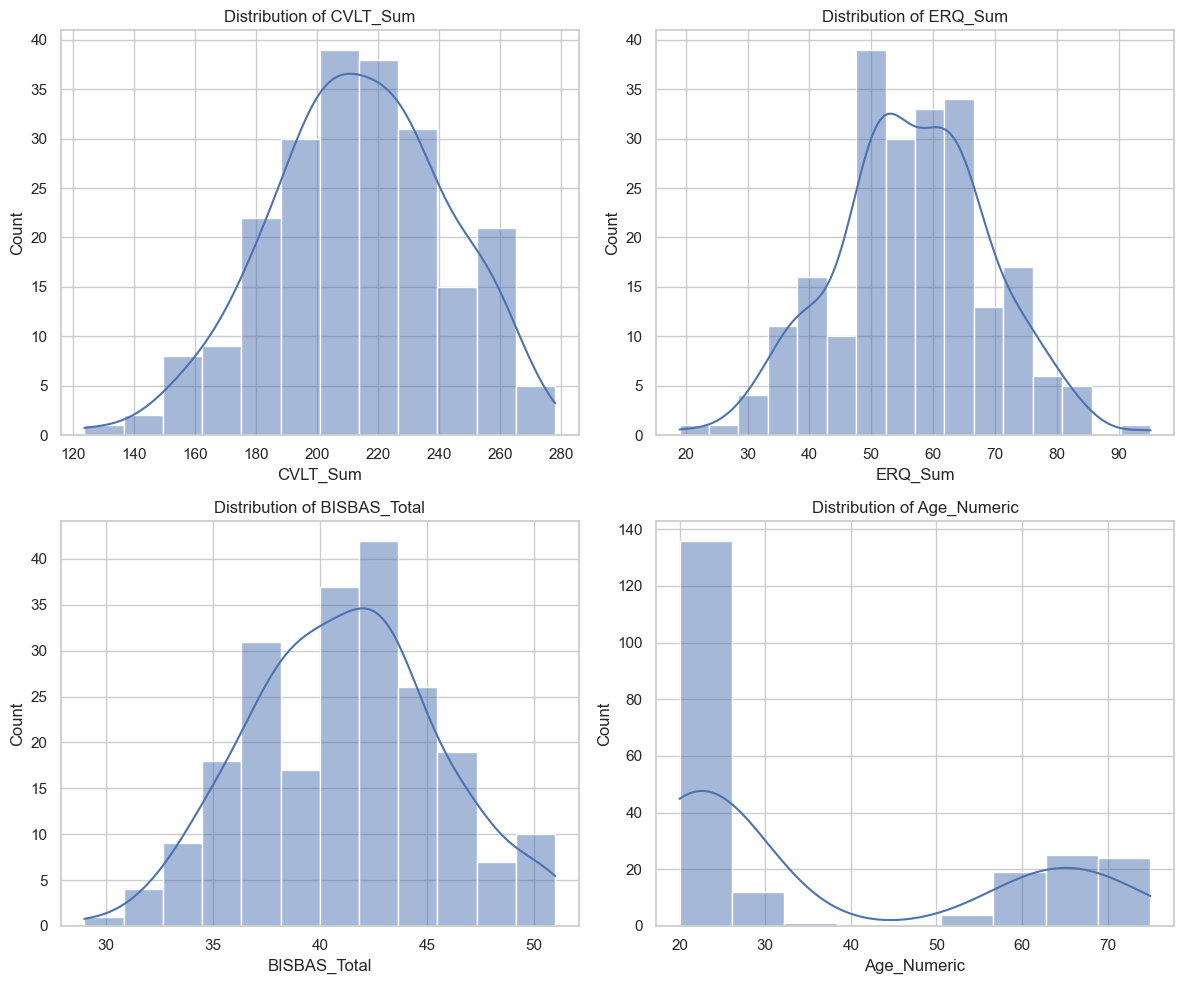

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn Style
sns.set(style="whitegrid")

# Plot Distributions of Key Features
key_features = ["CVLT_Sum", "ERQ_Sum", "BISBAS_Total", "Age_Numeric"]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, feature in zip(axes.flatten(), key_features):
    if feature in merged_data_clean.columns:
        sns.histplot(merged_data_clean[feature], kde=True, ax=ax)
        ax.set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()


### Distribution of Key Features

- **CVLT_Sum (California Verbal Learning Test):**  
  This test measures verbal learning and memory performance. A normal distribution is observed, with most scores clustering around 200–220. This suggests a typical cognitive performance in verbal learning across participants.

- **ERQ_Sum (Emotion Regulation Questionnaire):**  
  The ERQ assesses emotional regulation strategies, specifically *cognitive reappraisal* and *expressive suppression*. The distribution skews slightly right, with most scores between 50 and 70, indicating varying levels of emotional regulation among participants.

- **BISBAS_Total (Behavioral Inhibition and Activation System):**  
  The BIS/BAS scale measures motivational tendencies—BIS (inhibition for punishment) and BAS (activation for rewards). The distribution shows two peaks, suggesting the presence of distinct behavioral motivation patterns in the sample.

- **Age_Numeric:**  
  The age distribution is highly skewed, with most participants between 20–30 years old, and a smaller group in the 60–70 age range. This uneven age distribution will likely influence the `Relationship_Status`.

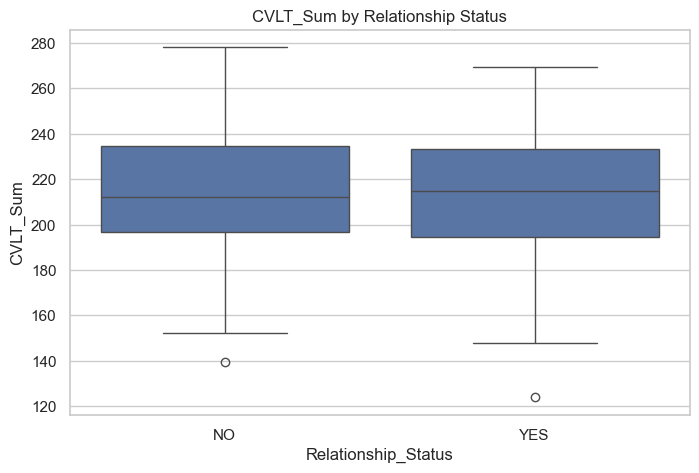

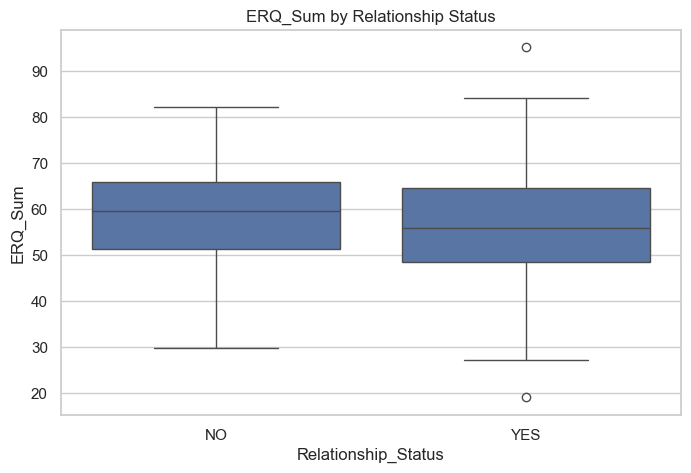

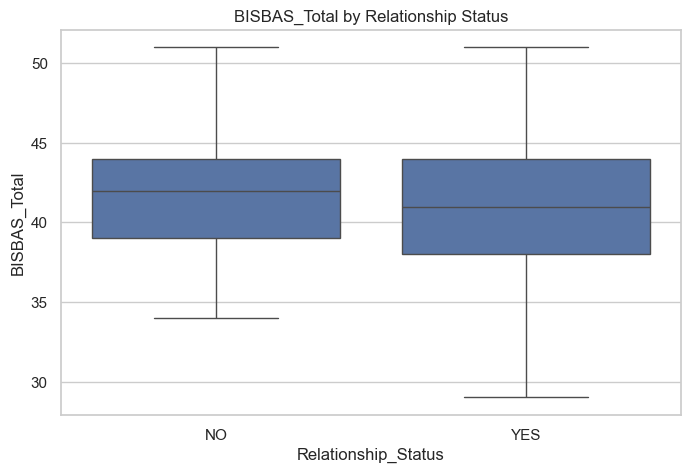

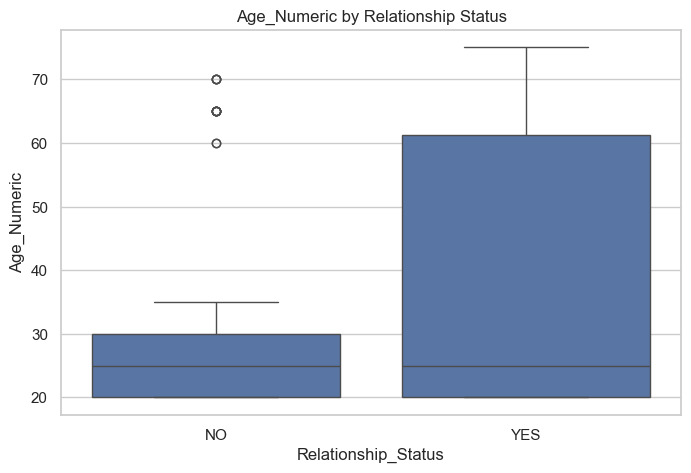

In [12]:
# Boxplots of Key Features by Relationship_Status
for feature in key_features:
    if feature in merged_data_clean.columns:
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=merged_data_clean, x="Relationship_Status", y=feature)
        plt.title(f"{feature} by Relationship Status")
        plt.show()

### CVLT_Sum by Relationship Status

- **Test Explanation:**  
  CVLT measures verbal memory performance by analyzing recall and learning of word lists.

- **Observation:**  
  Both groups (`YES` and `NO` for relationship status) show similar medians (~220) and overlapping interquartile ranges. This suggests that verbal memory performance (CVLT_Sum) does not strongly differentiate relationship status.


### ERQ_Sum by Relationship Status

- **Test Explanation:**  
  The ERQ evaluates two emotional regulation strategies: *reappraisal* (reframing a situation to alter its emotional impact) and *suppression* (inhibiting emotional expression).

- **Observation:**  
  The median scores for ERQ_Sum are similar across groups. However, participants in relationships (`YES`) appear to have slightly lower ERQ_Sum values, suggesting they might rely less on emotional suppression or reappraisal strategies compared to those not in relationships.

### BISBAS_Total by Relationship Status

- **Test Explanation:**  
  The BIS/BAS scale assesses motivational systems:
  - **BIS (Behavioral Inhibition System):** Sensitivity to punishment or fear of failure.
  - **BAS (Behavioral Activation System):** Drive and sensitivity to reward stimuli.

- **Observation:**  
  The distributions and medians of BISBAS_Total scores are very similar across relationship status groups. This indicates that motivational tendencies do not appear to strongly influence whether participants are in a relationship.


### Age_Numeric by Relationship Status

- **Test Explanation:**  
  Age is converted into numeric values to analyze its influence.

- **Observation:**  
  - Participants in relationships (`YES`) are predominantly older, with a wider age range including individuals aged 60–70.
  - Participants not in relationships (`NO`) are mostly younger (20–30).  
  This indicates that **age is a significant factor** for relationship status, with older individuals more likely to report being in a relationship.

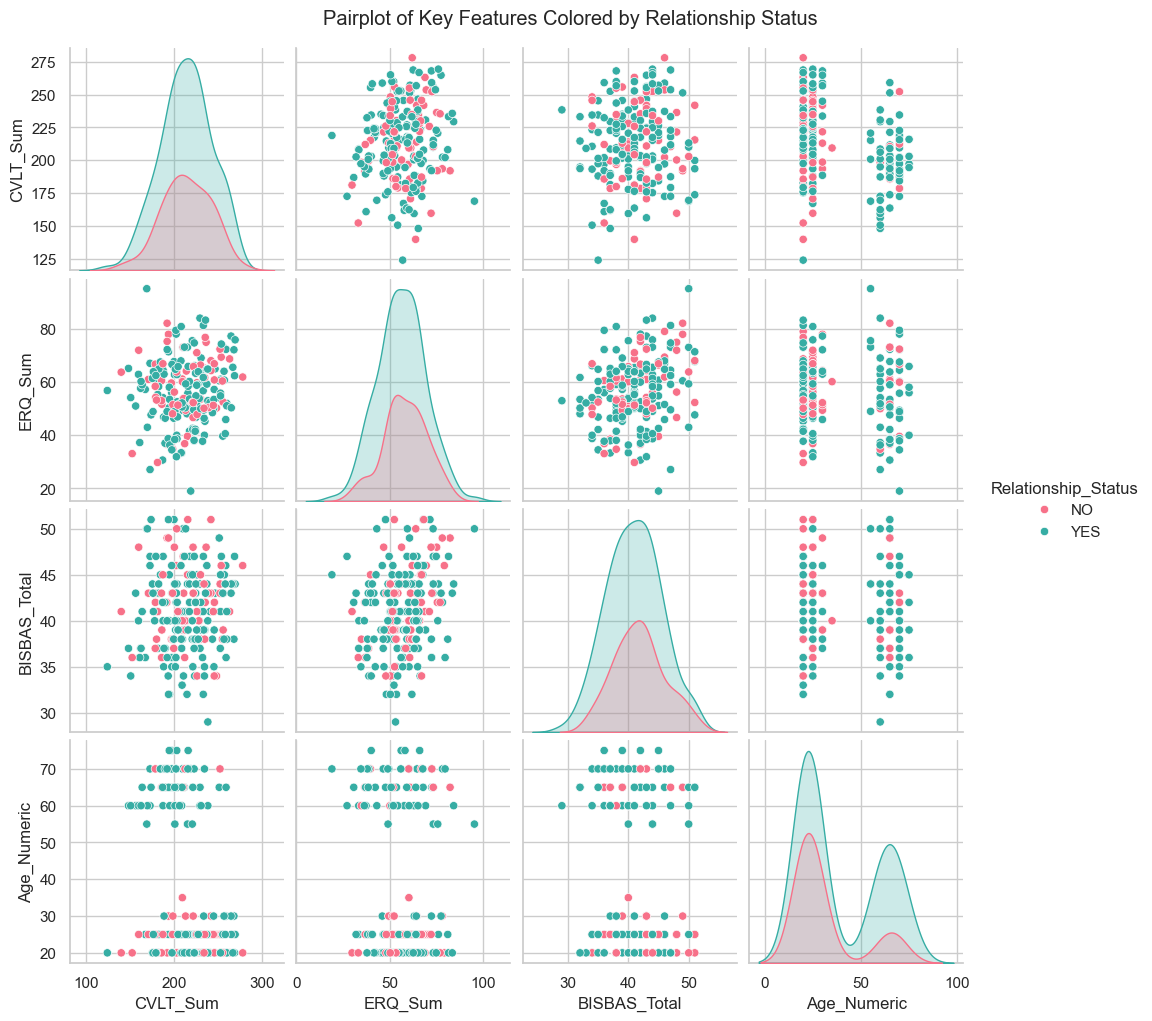

In [13]:
# Pairplot for Key Features and Relationship Status
selected_features = ["CVLT_Sum", "ERQ_Sum", "BISBAS_Total", "Age_Numeric", "Relationship_Status"]
existing_features = [f for f in selected_features if f in merged_data_clean.columns]

if len(existing_features) > 1:
    sns.pairplot(merged_data_clean[existing_features], hue="Relationship_Status", palette="husl")
    plt.suptitle("Pairplot of Key Features Colored by Relationship Status", y=1.02)
else:
    print("Not enough features for a pairplot.")

### Pairplot of Key Features

- **What it Shows:**  
  Pairwise relationships between key features (`CVLT_Sum`, `ERQ_Sum`, `BISBAS_Total`, `Age_Numeric`) are visualized, colored by `Relationship_Status`.

- **Observations:**
  - **Age_Numeric:** Strong separation between `YES` (older participants) and `NO` (younger participants).
  - **CVLT_Sum, ERQ_Sum, and BISBAS_Total:** Scattered and overlapping, showing weak separation between relationship groups.  
